# Filter female wavs

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
import os
import scipy 
import pandas as pd
import shutil

In [3]:
df=pd.read_csv(r"cremad\VideoDemographics.csv")
df.head(3)

,ActorID,Age,Sex,Race,Ethnicity
0,1001,51,Male,Caucasian,Not Hispanic
1,1002,21,Female,Caucasian,Not Hispanic
2,1003,21,Female,Caucasian,Not Hispanic


In [4]:
female_ids=[str(df.loc[i].iat[0]) for i in df.index if df.loc[i].iat[2]=="Female"]

In [5]:
audio_folder_name=r'cremad\AudioWAV'
dest_folder_name= r'cremad\FemaleAudioWAV'
file_names = listdir(audio_folder_name)
for f in file_names:
    
    x=f.split("_")
    if x[0] not in female_ids:
       continue
    #print(f)
    shutil.move(audio_folder_name + '\\' +f, dest_folder_name)
    

In [5]:
df_fem = df[df.Sex =='Female']
df_fem.head(5)

,ActorID,Age,Sex,Race,Ethnicity
1,1002,21,Female,Caucasian,Not Hispanic
2,1003,21,Female,Caucasian,Not Hispanic
3,1004,42,Female,Caucasian,Not Hispanic
5,1006,58,Female,Caucasian,Not Hispanic
6,1007,38,Female,African American,Not Hispanic


In [11]:
final_list= r'C:\Users\Tasli\Desktop\PythonFolder\SpeechEmotionClassifier\cremad\FemaleAudioWAV'
file_names = listdir(final_list)
df2 = pd.DataFrame(file_names,columns=['Filename'])
df2.head()

,Filename
0,1002_DFA_ANG_XX.wav
1,1002_DFA_DIS_XX.wav
2,1002_DFA_FEA_XX.wav
3,1002_DFA_HAP_XX.wav
4,1002_DFA_NEU_XX.wav


In [18]:
def getEmotion(x):
    part = x.split('_')
    if part[2] == 'SAD':
        return 'sad'
    elif part[2] == 'ANG':
        return 'angry'
    elif part[2] == 'DIS':
        return 'disgust'
    elif part[2] == 'FEA':
        return 'fear'
    elif part[2] == 'HAP':
        return 'happy'
    elif part[2] == 'NEU':
        return 'neutral'
    else:
        return 'Unknown'
    
df2['Emotion'] = df2['Filename'].apply(getEmotion)


df2.Emotion.value_counts()

angry      600
disgust    600
happy      600
sad        600
fear       600
neutral    512
Name: Emotion, dtype: int64

In [23]:
def getLength(filename):
    audio_path = final_list + '\\' + filename
    data, sr = librosa.load(audio_path, sr = 22050)
    return np.size(data,0)/22050

df2['Length'] = df2['Filename'].apply(getLength)

df2.head(5)

,Filename,Emotion,Length
0,1002_DFA_ANG_XX.wav,angry,2.569252
1,1002_DFA_DIS_XX.wav,disgust,2.535918
2,1002_DFA_FEA_XX.wav,fear,2.736100
3,1002_DFA_HAP_XX.wav,happy,2.202222
4,1002_DFA_NEU_XX.wav,neutral,2.502540


In [25]:
df2.groupby(['Emotion']).mean()

,Length
Emotion,
angry,2.592484
disgust,2.812258
fear,2.551843
happy,2.365023
neutral,2.481414
sad,2.629143


In [26]:
df2.groupby(['Emotion']).min()

,Filename,Length
Emotion,,
angry,1002_DFA_ANG_XX.wav,1.501542
disgust,1002_DFA_DIS_XX.wav,1.568254
fear,1002_DFA_FEA_XX.wav,1.501542
happy,1002_DFA_HAP_XX.wav,1.334694
neutral,1002_DFA_NEU_XX.wav,1.401406
sad,1002_DFA_SAD_XX.wav,1.468163


In [27]:
df2.groupby(['Emotion']).max()

,Filename,Length
Emotion,,
angry,1091_WSI_ANG_XX.wav,4.971655
disgust,1091_WSI_DIS_XX.wav,4.871565
fear,1091_WSI_FEA_XX.wav,4.537914
happy,1091_WSI_HAP_XX.wav,3.903900
neutral,1091_WSI_NEU_XX.wav,4.771474
sad,1091_WSI_SAD_XX.wav,5.005034


# Convert to mel specs

In [33]:
##FUNCTIONS
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(1):
        for y in range(1):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
            
def convert_single_audio_to_image(audio_path, image_path, spectrogram_dimensions = (64,64)):
    data, sr = librosa.load(audio_path, sr = 22050)
    signals ={1:data}
    plot_signals(signals)
    print("sr={}".format(sr))
    #Make a mel spectrogram from audio
    window_width =  0.025 #25 ms  window size 
    sliding = 0.01 #10ms stride 
    print("Length of audio:", np.size(data,0)/22050)
    spec = librosa.feature.melspectrogram(y=data, sr=sr, n_fft = int(window_width*sr), hop_length =int(sliding*sr))
    print(spec.shape)
    
    #Convert amplitude to decibels
    db_spec = librosa.power_to_db(spec, ref=np.max)

    #fig.set_size_inches((spectrogram_dimensions[0]/fig.get_dpi(), spectrogram_dimensions[1]/fig.get_dpi()))
    #Iterate over time in 100 ms steps, produce mel-specs with 100ms time
    for x in range(0,np.size(db_spec,1), 10):
        fig = plt.figure()
        #Display final mel spectrogram
        librosa.display.specshow(np.reshape(np.copy(db_spec[:,x:x+10]),(128,-1)), sr=sr,x_axis='time',y_axis='mel', hop_length =int(sliding*sr))
        plt.colorbar()
        file_end = "%d.png" %(x)
        fig.savefig(image_path.replace('.png',file_end))
        plt.close(fig)


count of Wav_files in 28= cremad\AudioWAV\sam
1001_IEO_ANG_MD.wav
sr=22050
Length of audio: 2.635963718820862
(128, 265)
1001_IEO_ANG_MD0.png


NoBackendError: 

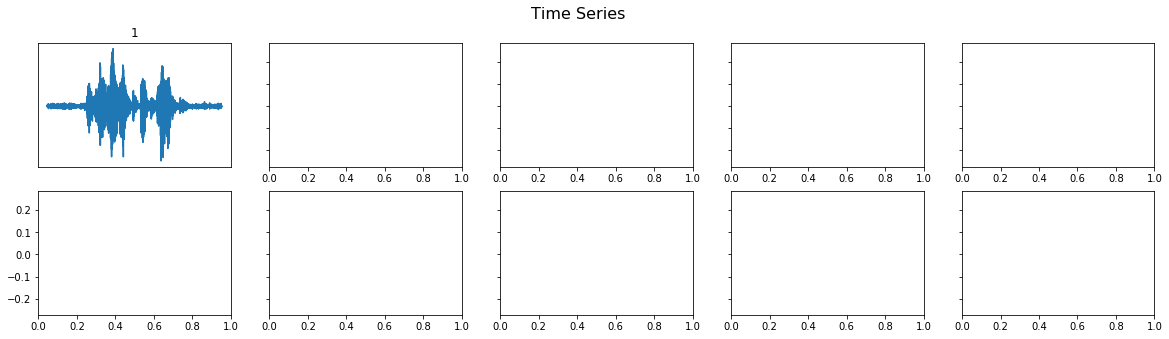

In [34]:
if __name__ == '__main__':
    audio_folder_name= r"cremad\AudioWAV\sam"
    image_folder_name=  r"cremad\AudioWAV\sam"
    file_names = listdir(audio_folder_name)
#     file_names = [f for f in listdir(audio_folder_name)]
    print("count of Wav_files in {}= {}".format(len(file_names),audio_folder_name))
    for file_name in file_names:
        name, ext = os.path.splitext(file_name)
        print(file_name)
            
        audio_path = audio_folder_name + '\\' + file_name
        spectogram_path = image_folder_name + '\\' + file_name.replace('.wav', '.png')
        convert_single_audio_to_image(audio_path,spectogram_path)
    image_files= listdir(image_folder_name)
    print("count of Wav_files in {}= {}".format(len(image_files),image_folder_name))